In [ ]:
def get_new_feature_name_df(old_feature_name_df) :
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby("column_name").cumcount(),
                                  columns=["dup_cnt"])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how="outer")
    new_feature_name_df["column_name"] = new_feature_name_df[["column_name", "dup_cnt"]].apply(lambda x : x[0]+"_"+str(x[1])
                                                                                        if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(["index"], axis=1)
    return new_feature_name_df

In [ ]:
def get_human_dataset() :

    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    featuer_name_df = pd.read_csv("./csv_data/UCI HAR Dataset/UCI HAR Dataset/features.txt", sep="\s+",
                              header=None, names=["column_index", "column_name"])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df() 를 이용, 신규 피처명 DF 생성
    new_feature_name_df = get_new_feature_name_df(featuer_name_df)

    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    featuer_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터 셋과 테스스 피처 데이터를 DF로 로딩, 컬럼명은 feature_name 적용
    X_train = pd.read_csv("./csv_data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt",
                          sep="\s+", names=featuer_name)
    X_test = pd.read_csv("./csv_data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt",
                          sep="\s+", names=featuer_name)

    # 학습 레이블과 테스트 레이블 데이터를 DF로 로딩하고 컬럼명은 action으로 부여
    # "\s+" 데이터 사이 간격 공백으로 구분
    y_train = pd.read_csv("./csv_data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt",
                          sep="\s+", header=None, names=["action"])
    y_test = pd.read_csv("./csv_data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt",
                          sep="\s+", header=None, names=["action"])

    # 로드된 학습/테스트용 DF를 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# 결정 트리에서 사용한 get_human_dataset()을 이용해 DF반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f"랜덤 포레스트 정확도 : {accuracy:.4f}")

C:\Users\user\AppData\Local\Temp\ipykernel_3876\2941422834.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


랜덤 포레스트 정확도 : 0.9253


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators" : [100],
    "max_depth" : [6, 8, 10, 12],
    "min_samples_leaf" : [8, 12, 18],
    "min_samples_split" : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSerchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)  # pc의 모든 리소스 사용
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print(f"최적 하이퍼 파라미터 : \n {grid_cv.best_params_}")
print(f"최고 예측 정확도 : {grid_cv.best_score_:.4f}")

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


최적 하이퍼 파라미터 : 
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도 : 0.9180


In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8,
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print(f"예측 정확도 : {accuracy_score(y_test, pred):.4f}")

C:\Users\user\AppData\Local\Temp\ipykernel_3876\2851593926.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf1.fit(X_train, y_train)


예측 정확도 : 0.9165


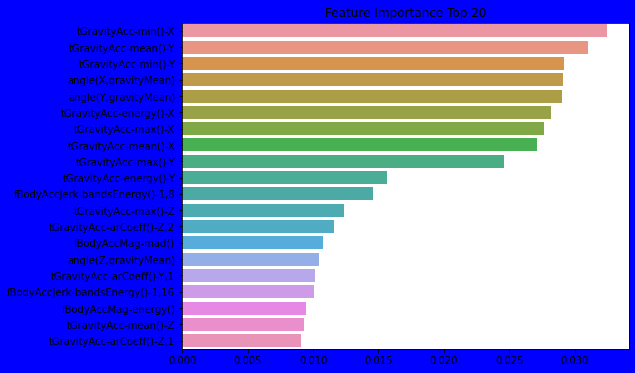

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ftr_importance_values = rf_clf1.feature_importances_
ftr_importance = pd.Series(ftr_importance_values, index=X_train.columns)
ftr_top20 = ftr_importance.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title("Feature Importance Top 20")
sns.barplot(x=ftr_top20, y = ftr_top20.index)
plt.show()